In [ ]:
from all_models.models.discrepancy import Detectorbydisc
from all_models.models.Dataset import Dataset
from all_models.models.evaluate import evaluate
from all_models.models.grammarflaw import GrammarFlaw
from all_models.models.perplexity import perplexity
import torch,pickle,random,copy
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def save(filepath,obj):
    with open(filepath,'wb') as file:
        pickle.dump(obj,file)
def load(filepath):
    with open(filepath,'rb') as file:
        return pickle.load(file)

#### For presentation, we write two short little sentences to see it functions as we expect

In [ ]:
text = "Yesterday, a man named Jack said he saw an alien. The alien was huge."
detectdisc=Detectorbydisc(threshold=0)

In [3]:
detectdisc.get_discrepancy(text,show_perturb=True,show_discrepancy=True)

Yesterday, a man named Jack said he saw an alien
yesterday, a boy named jack told he saw an alien
yesterday, an boy named jack told he saw an alien
yesterday, some guy named jack said he saw an alien
yesterday, an someone named jack said he saw an alien
yesterday, our man named jack called he saw an alien
The alien was huge
the thing was huge
the entity was huge
the creature was huge
the aliens was huge
the creature was huge
the discrepancy is -1.3547675609588623


-1.3547675609588623

#### Here we use 50 texts as validation sets to finetune the hyperparameters and another 50 texts to test.

In [ ]:
data=Dataset(0,'./Dataset/intro1.csv')
data.make_batch(25,1)
thresholds=torch.linspace(-2.8,-0.8,20)
score=[]
for i in thresholds:
    model=Detectorbydisc(threshold=i)
    model.eval=True
    score.append(evaluate(model,data.batches[0]))


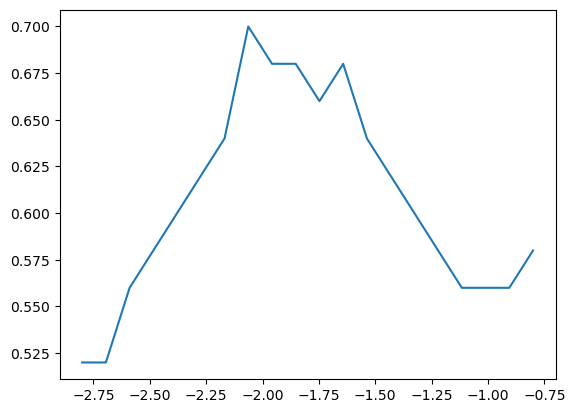

In [9]:
plt.plot(thresholds,score)

#### Currently with other hypers stay initialized the best threshold is -2.0632

In [ ]:
threshold=-2.0632
data=Dataset(0,'./Dataset/intro1.csv')
data.make_batch(25,1)
ratios=torch.linspace(0.01,1,20)
score=[]
for i in ratios:
    model=Detectorbydisc(threshold=threshold,ratio=i)
    model.eval=True
    score.append(evaluate(model,data.batches[0]))

In [23]:
ratios[5]

tensor(0.2705)

In [ ]:
threshold=-2.0632
data=Dataset(0,'./Dataset/intro1.csv')
data.make_batch(25,1)
ratios=torch.linspace(0.01,1,20)
score=[]
for i in ratios:
    model=Detectorbydisc(threshold=threshold,ratio=i)
    model.eval=True
    score.append(evaluate(model,data.batches[0]))

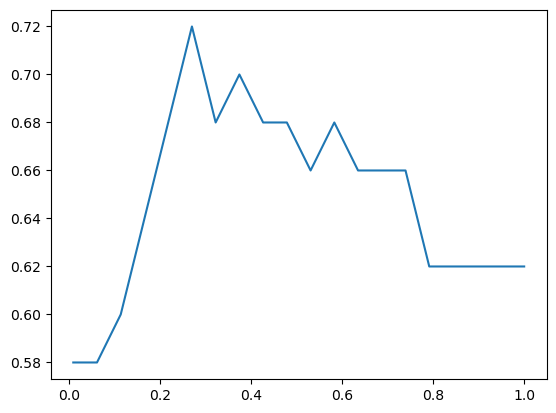

In [26]:
plt.plot(ratios,score)

#### the best ratio under the current choice of threshold is 0.2705.

#### test it on a set of 500 texts

In [33]:
model=Detectorbydisc(threshold=-2.0632,ratio=0.2705)
model.eval=True
evaluate(model,data.batches[1])

0.65965966


#### the accuracy on test set is 0.66

## Watermark: The grammar flaw

In [13]:
def random_perturb_be(sentence):
    be_forms = ["is", "are", "am", "was", "were", "be", "being"]

    words = sentence.split()
    for i, word in enumerate(words):
        if word == "is":
            new_be = random.choice([b for b in be_forms if b != word and b != "was"])
            words[i] = new_be
            break
        elif word == "are":
            new_be = random.choice([b for b in be_forms if b != word and b != "were"])
            words[i] = new_be
            break
        elif word == "am":
            new_be = random.choice([b for b in be_forms if b != word and b != "was"])
            words[i] = new_be
            break
        elif word == "was":
            new_be = random.choice(
                [b for b in be_forms if b != word and b != "is" and b != "am"]
            )
            words[i] = new_be
            break
        elif word == "were":
            new_be = random.choice([b for b in be_forms if b != word and b != "are"])
            words[i] = new_be
            break
        elif word in be_forms:
            new_be = random.choice([b for b in be_forms if b != word])
            words[i] = new_be
            break

    return " ".join(words)

#### Load right sentences and purturb the 'be' in each

In [64]:
flaw=GrammarFlaw(max_length=16)
rightsentences=load('./Dataset/besentences.pkl')
wrongsentences=list(map(random_perturb_be,rightsentences))
for i in range(5):
    print(rightsentences[i])
    print(wrongsentences[i])


There is a beautiful garden beyond the hills.
There were a beautiful garden beyond the hills.
She is reading a book under the old oak tree.
She am reading a book under the old oak tree.
I am thinking about the mysteries of the universe.
I being thinking about the mysteries of the universe.
This book was written by a famous author.
This book were written by a famous author.
They are planning to visit the new museum downtown.
They am planning to visit the new museum downtown.


In [65]:
right=Dataset(0,'./Dataset/right.csv')
wrong=Dataset(0,'./Dataset/wrong.csv')
right.make_batch(500,1)
wrong.make_batch(500,1)
trainset=Dataset(1,data=pd.concat((right.batches[0].data,wrong.batches[0].data),axis=0))
testset=Dataset(1,data=pd.concat((right.data.drop(right.batches[0].data.index),wrong.data.drop(wrong.batches[0].data.index)),axis=0))


In [70]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(flaw.parameters(), lr=0.0001)
flaw.trainfunc(trainset,optimizer=optimizer,criterion=criterion,epochs=5000)

Train Epoch: 0 	Loss: 0.571510
Train Epoch: 5 	Loss: 0.560346
Train Epoch: 10 	Loss: 0.549494
Train Epoch: 15 	Loss: 0.538745
Train Epoch: 20 	Loss: 0.527968
Train Epoch: 25 	Loss: 0.517135
Train Epoch: 30 	Loss: 0.506156
Train Epoch: 35 	Loss: 0.494989
Train Epoch: 40 	Loss: 0.483581
Train Epoch: 45 	Loss: 0.471937
Train Epoch: 50 	Loss: 0.460170
Train Epoch: 55 	Loss: 0.448344
Train Epoch: 60 	Loss: 0.436550
Train Epoch: 65 	Loss: 0.424739
Train Epoch: 70 	Loss: 0.412945
Train Epoch: 75 	Loss: 0.401217
Train Epoch: 80 	Loss: 0.389541
Train Epoch: 85 	Loss: 0.377977
Train Epoch: 90 	Loss: 0.366506
Train Epoch: 95 	Loss: 0.355170
Train Epoch: 100 	Loss: 0.344026
Train Epoch: 105 	Loss: 0.333082
Train Epoch: 110 	Loss: 0.322347
Train Epoch: 115 	Loss: 0.311816
Train Epoch: 120 	Loss: 0.301474
Train Epoch: 125 	Loss: 0.291314
Train Epoch: 130 	Loss: 0.281344
Train Epoch: 135 	Loss: 0.271577
Train Epoch: 140 	Loss: 0.262034
Train Epoch: 145 	Loss: 0.252742
Train Epoch: 150 	Loss: 0.243693

KeyboardInterrupt: 

In [77]:
flaw=GrammarFlaw(max_length=16)
flaw.loadmodel()
flaw.eval()
test_target=torch.tensor(list(testset.data['right']),dtype=torch.long)
output=flaw(testset).argmax(dim=1)
accuracy_score(test_target,output)

0.9830508474576272

### the accuracy on test set is 0.983, finally let's how it works as a bias on the current model we have (the perplexity). To emphasize its function we slightly modify the dataset so that there are some grammar mistakes involved. 

#### First we finetune some hypers on validation set

In [131]:
gram=GrammarFlaw()
gram.loadmodel()
validdata=Dataset(0,'./Dataset/grammarvalid.csv')

In [132]:
a=gram(validdata,name='wiki_intro').detach()
wiki_bias=a[:,1]-a[:,0]
validdata.data['wiki_bias']=wiki_bias
a=gram(validdata,name='generated_intro').detach()
generated_bias=a[:,1]-a[:,0]
validdata.data['generated_bias']=generated_bias
validdata.data['wiki_bias']=validdata.data['wiki_bias'].apply(lambda x:1 if x>0 else 0)
validdata.data['generated_bias']=validdata.data['generated_bias'].apply(lambda x:1 if x>0 else 0)

In [162]:
def accu(threshold):
    score=0
    for item in wikippl:
        if item>threshold:
            score+=1
    for item in generatedppl:
        if item<threshold:
            score+=1
    return score/len(wikippl)/2
model=perplexity(threshold=15,separately=False,labelorppl='ppl')
accuracies=[]
biasscale=10
wikippl=[model(text,bias*biasscale) for text,bias in zip(validdata.data['wiki_intro'],validdata.data['wiki_bias'])]
generatedppl=[model(text,bias*biasscale) for text,bias in zip(validdata.data['generated_intro'],validdata.data['generated_bias'])]
bestaccu=0
for threshold in torch.linspace(10,50,81):
    if accu(threshold)>bestaccu:
        bestaccu=accu(threshold)
        bestthreshold=threshold
accuracies.append((bestaccu,bestthreshold))

In [4]:
accuracies

[(0.94, tensor(16.5000))]


#### Then test it on test set

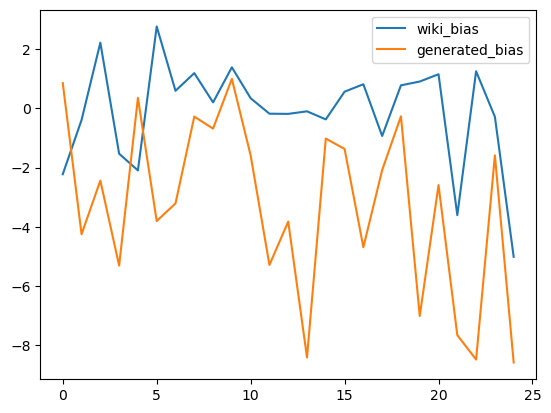

In [155]:
testdata=Dataset(0,'./Dataset/grammartest.csv')
a=gram(testdata,name='wiki_intro').detach()
wiki_bias=a[:,1]-a[:,0]
testdata.data['wiki_bias']=wiki_bias
a=gram(testdata,name='generated_intro').detach()
generated_bias=a[:,1]-a[:,0]
testdata.data['generated_bias']=generated_bias
plt.plot(testdata.data['wiki_bias'],label='wiki_bias')
plt.plot(testdata.data['generated_bias'],label='generated_bias')
plt.legend()
testdata.data['wiki_bias']=testdata.data['wiki_bias'].apply(lambda x:1 if x>0 else 0)
testdata.data['generated_bias']=testdata.data['generated_bias'].apply(lambda x:1 if x>0 else 0)

In [172]:
wikippl=[model(text,bias*biasscale) for text,bias in zip(testdata.data['wiki_intro'],testdata.data['wiki_bias'])]
generatedppl=[model(text,bias*biasscale) for text,bias in zip(testdata.data['generated_intro'],testdata.data['generated_bias'])]
accu(threshold=16.5)

0.9

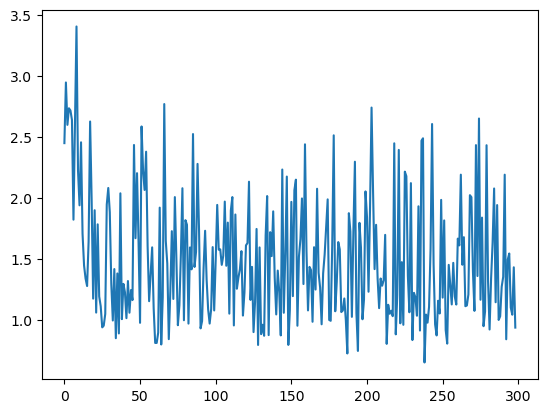

In [9]:
with open('../cache/loss','r') as file:
    loss=file.readlines()
loss = [s.rstrip("\n") for s in loss[2:]]
loss=np.array(loss,dtype=float)
plt.plot(loss)